In [3]:
import os
print("Current working directory:", os.getcwd())
print("Files in current directory:", os.listdir('.'))
if os.path.exists('data'):
    print("✓ 'data' folder found!")
    print("Contents of 'data/raw':", os.listdir('data/raw'))
else:
    print("❌ 'data' folder not found")

Current working directory: C:\Users\cheta\OneDrive\Desktop\fake-news-detection-genai
Files in current directory: ['.git', '.ipynb_checkpoints', '.virtual_documents', 'data', 'models', 'naive_bayes_comparison.ipynb-Copy1.ipynb', 'naive_bayes_comparison.ipynb.ipynb', 'notebooks', 'README.md']
✓ 'data' folder found!
Contents of 'data/raw': ['Fake.csv', 'IFND.csv', 'True.csv']


In [4]:
# ================================================================
# FAKE NEWS DETECTION - NAIVE BAYES VS LOGISTIC REGRESSION
# ================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [5]:
# ================================================================
# LOAD DATA
# ================================================================

print("Loading datasets...")

# Load Fake news
fake_df = pd.read_csv('data/raw/Fake.csv')
fake_df['label'] = 0  # 0 = Fake

# Load True news
true_df = pd.read_csv('data/raw/True.csv')
true_df['label'] = 1  # 1 = True

# Combine both datasets
df = pd.concat([fake_df, true_df], ignore_index=True)

print(f"✓ Dataset loaded successfully!")
print(f"  Total articles: {len(df)}")
print(f"  Fake news: {len(fake_df)}")
print(f"  True news: {len(true_df)}")
print(f"\nColumns: {df.columns.tolist()}")

# Display first few rows
df.head()

Loading datasets...
✓ Dataset loaded successfully!
  Total articles: 44898
  Fake news: 23481
  True news: 21417

Columns: ['title', 'text', 'subject', 'date', 'label']


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [6]:
# ================================================================
# EXPLORE DATA
# ================================================================

print("Dataset Information:")
print(f"Shape: {df.shape}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nClass distribution:\n{df['label'].value_counts()}")

# Check what columns we have
print(f"\nAvailable columns: {df.columns.tolist()}")

Dataset Information:
Shape: (44898, 5)

Missing values:
title      0
text       0
subject    0
date       0
label      0
dtype: int64

Class distribution:
label
0    23481
1    21417
Name: count, dtype: int64

Available columns: ['title', 'text', 'subject', 'date', 'label']


In [7]:
# ================================================================
# PREPARE TEXT DATA
# ================================================================

# Combine title and text (if both exist)
# Check which columns exist and use them
if 'title' in df.columns and 'text' in df.columns:
    df['content'] = df['title'] + " " + df['text']
elif 'text' in df.columns:
    df['content'] = df['text']
elif 'title' in df.columns:
    df['content'] = df['title']
else:
    # Use the first text column we find
    text_col = df.select_dtypes(include=['object']).columns[0]
    df['content'] = df[text_col]

# Remove missing values
df = df.dropna(subset=['content'])

print(f"✓ Data prepared!")
print(f"  Final dataset size: {len(df)} articles")
print(f"  Average article length: {df['content'].str.len().mean():.0f} characters")

✓ Data prepared!
  Final dataset size: 44898 articles
  Average article length: 2550 characters


In [8]:
# ================================================================
# CREATE TF-IDF FEATURES
# ================================================================

print("\nCreating TF-IDF features...")

# Prepare X and y
X_text = df['content']
y = df['label']

# Split data FIRST (to prevent data leakage)
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Ensures balanced split
)

# Create TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,      # Top 5000 words
    ngram_range=(1, 2),     # Unigrams and bigrams
    max_df=0.9,             # Ignore words in >90% of documents
    min_df=5,               # Ignore words in <5 documents
    stop_words='english'    # Remove common English words
)

# Fit on training data only
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

print(f"✓ TF-IDF features created!")
print(f"  Training set: {X_train_tfidf.shape}")
print(f"  Test set: {X_test_tfidf.shape}")
print(f"  Vocabulary size: {len(tfidf.vocabulary_)}")


Creating TF-IDF features...
✓ TF-IDF features created!
  Training set: (35918, 5000)
  Test set: (8980, 5000)
  Vocabulary size: 5000


In [9]:
# ================================================================
# MODEL 1: LOGISTIC REGRESSION
# ================================================================

print("\n" + "="*60)
print("TRAINING LOGISTIC REGRESSION")
print("="*60)

import time
start_time = time.time()

lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42
)
lr_model.fit(X_train_tfidf, y_train)

lr_train_time = time.time() - start_time

# Make predictions
lr_pred = lr_model.predict(X_test_tfidf)

# Calculate metrics
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred, average='weighted')
lr_recall = recall_score(y_test, lr_pred, average='weighted')
lr_f1 = f1_score(y_test, lr_pred, average='weighted')

print(f"✓ Training completed in {lr_train_time:.2f} seconds")
print(f"\nPerformance:")
print(f"  Accuracy:  {lr_accuracy:.4f}")
print(f"  Precision: {lr_precision:.4f}")
print(f"  Recall:    {lr_recall:.4f}")
print(f"  F1-Score:  {lr_f1:.4f}")


TRAINING LOGISTIC REGRESSION
✓ Training completed in 0.33 seconds

Performance:
  Accuracy:  0.9889
  Precision: 0.9889
  Recall:    0.9889
  F1-Score:  0.9889


In [10]:
# ================================================================
# MODEL 2: NAIVE BAYES
# ================================================================

print("\n" + "="*60)
print("TRAINING NAIVE BAYES")
print("="*60)

start_time = time.time()

nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train_tfidf, y_train)

nb_train_time = time.time() - start_time

# Make predictions
nb_pred = nb_model.predict(X_test_tfidf)

# Calculate metrics
nb_accuracy = accuracy_score(y_test, nb_pred)
nb_precision = precision_score(y_test, nb_pred, average='weighted')
nb_recall = recall_score(y_test, nb_pred, average='weighted')
nb_f1 = f1_score(y_test, nb_pred, average='weighted')

print(f"✓ Training completed in {nb_train_time:.2f} seconds")
print(f"\nPerformance:")
print(f"  Accuracy:  {nb_accuracy:.4f}")
print(f"  Precision: {nb_precision:.4f}")
print(f"  Recall:    {nb_recall:.4f}")
print(f"  F1-Score:  {nb_f1:.4f}")


TRAINING NAIVE BAYES
✓ Training completed in 0.02 seconds

Performance:
  Accuracy:  0.9451
  Precision: 0.9451
  Recall:    0.9451
  F1-Score:  0.9451


In [17]:
# ================================================================
# MODEL 3: RANDOM FOREST
# ================================================================

print("\n" + "="*60)
print("TRAINING RANDOM FOREST")
print("="*60)

from sklearn.ensemble import RandomForestClassifier
import time

start_time = time.time()

rf_model = RandomForestClassifier(
    n_estimators=100,      # Number of trees (reduce to 50 if too slow)
    random_state=42,       # For reproducibility
    n_jobs=-1              # Use all CPU cores
)
rf_model.fit(X_train_tfidf, y_train)

rf_train_time = time.time() - start_time

# Make predictions
rf_pred = rf_model.predict(X_test_tfidf)

# Calculate metrics
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred, average='weighted')
rf_recall = recall_score(y_test, rf_pred, average='weighted')
rf_f1 = f1_score(y_test, rf_pred, average='weighted')

print(f"✓ Training completed in {rf_train_time:.2f} seconds")
print(f"\nPerformance:")
print(f"  Accuracy:  {rf_accuracy:.4f}")
print(f"  Precision: {rf_precision:.4f}")
print(f"  Recall:    {rf_recall:.4f}")
print(f"  F1-Score:  {rf_f1:.4f}")


TRAINING RANDOM FOREST
✓ Training completed in 4.03 seconds

Performance:
  Accuracy:  0.9989
  Precision: 0.9989
  Recall:    0.9989
  F1-Score:  0.9989


In [18]:
# DEBUG CELL: Check if variables are defined
try:
    print("Logistic Regression:", lr_accuracy, lr_precision)
    print("Naive Bayes:", nb_accuracy, nb_precision)
    print("Random Forest:", rf_accuracy, rf_precision)
    print("✓ All variables defined!")
except NameError as e:
    print(f"❌ Error: {e}. Rerun the corresponding cell.")

Logistic Regression: 0.9888641425389755 0.9888894192140755
Naive Bayes: 0.9451002227171492 0.9451188839079104
Random Forest: 0.9988864142538976 0.9988864142538976
✓ All variables defined!


In [19]:
# ================================================================
# MODEL COMPARISON (UPDATED FOR 3 MODELS)
# ================================================================

print("\n" + "="*60)
print("MODEL COMPARISON RESULTS")
print("="*60)

# Create comparison dataframe (now with 3 models)
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes', 'Random Forest'],
    'Accuracy': [lr_accuracy, nb_accuracy, rf_accuracy],
    'Precision': [lr_precision, nb_precision, rf_precision],
    'Recall': [lr_recall, nb_recall, rf_recall],
    'F1-Score': [lr_f1, nb_f1, rf_f1],
    'Training Time (s)': [lr_train_time, nb_train_time, rf_train_time]
})

print("\n", comparison_df.to_string(index=False))

# Determine best model
best_f1 = max(lr_f1, nb_f1, rf_f1)
if rf_f1 == best_f1:
    best_model = "Random Forest"
elif nb_f1 == best_f1:
    best_model = "Naive Bayes"
else:
    best_model = "Logistic Regression"

print(f"\n🏆 Best Model: {best_model} (F1-Score: {best_f1:.4f})")
print(f"\n⏱️  Training times: LR={lr_train_time:.2f}s, NB={nb_train_time:.2f}s, RF={rf_train_time:.2f}s")


MODEL COMPARISON RESULTS

               Model  Accuracy  Precision   Recall  F1-Score  Training Time (s)
Logistic Regression  0.988864   0.988889 0.988864  0.988866           0.328206
        Naive Bayes  0.945100   0.945119 0.945100  0.945105           0.017447
      Random Forest  0.998886   0.998886 0.998886  0.998886           4.028735

🏆 Best Model: Random Forest (F1-Score: 0.9989)

⏱️  Training times: LR=0.33s, NB=0.02s, RF=4.03s


In [21]:
# ================================================================
# DETAILED CLASSIFICATION REPORTS
# ================================================================

print("\n" + "="*60)
print("LOGISTIC REGRESSION - DETAILED REPORT")
print("="*60)
print(classification_report(y_test, lr_pred, target_names=['Fake', 'True']))

print("\n" + "="*60)
print("NAIVE BAYES - DETAILED REPORT")
print("="*60)
print(classification_report(y_test, nb_pred, target_names=['Fake', 'True']))

print("\n" + "="*60)
print("RANDOM FOREST - DETAILED REPORT")
print("="*60)
print(classification_report(y_test, rf_pred, target_names=['Fake', 'True']))


LOGISTIC REGRESSION - DETAILED REPORT
              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      4696
        True       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980


NAIVE BAYES - DETAILED REPORT
              precision    recall  f1-score   support

        Fake       0.95      0.95      0.95      4696
        True       0.94      0.94      0.94      4284

    accuracy                           0.95      8980
   macro avg       0.94      0.95      0.94      8980
weighted avg       0.95      0.95      0.95      8980


RANDOM FOREST - DETAILED REPORT
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4696
        True       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00  


Creating visualizations...
✓ Visualization saved to: models/model_comparison.png


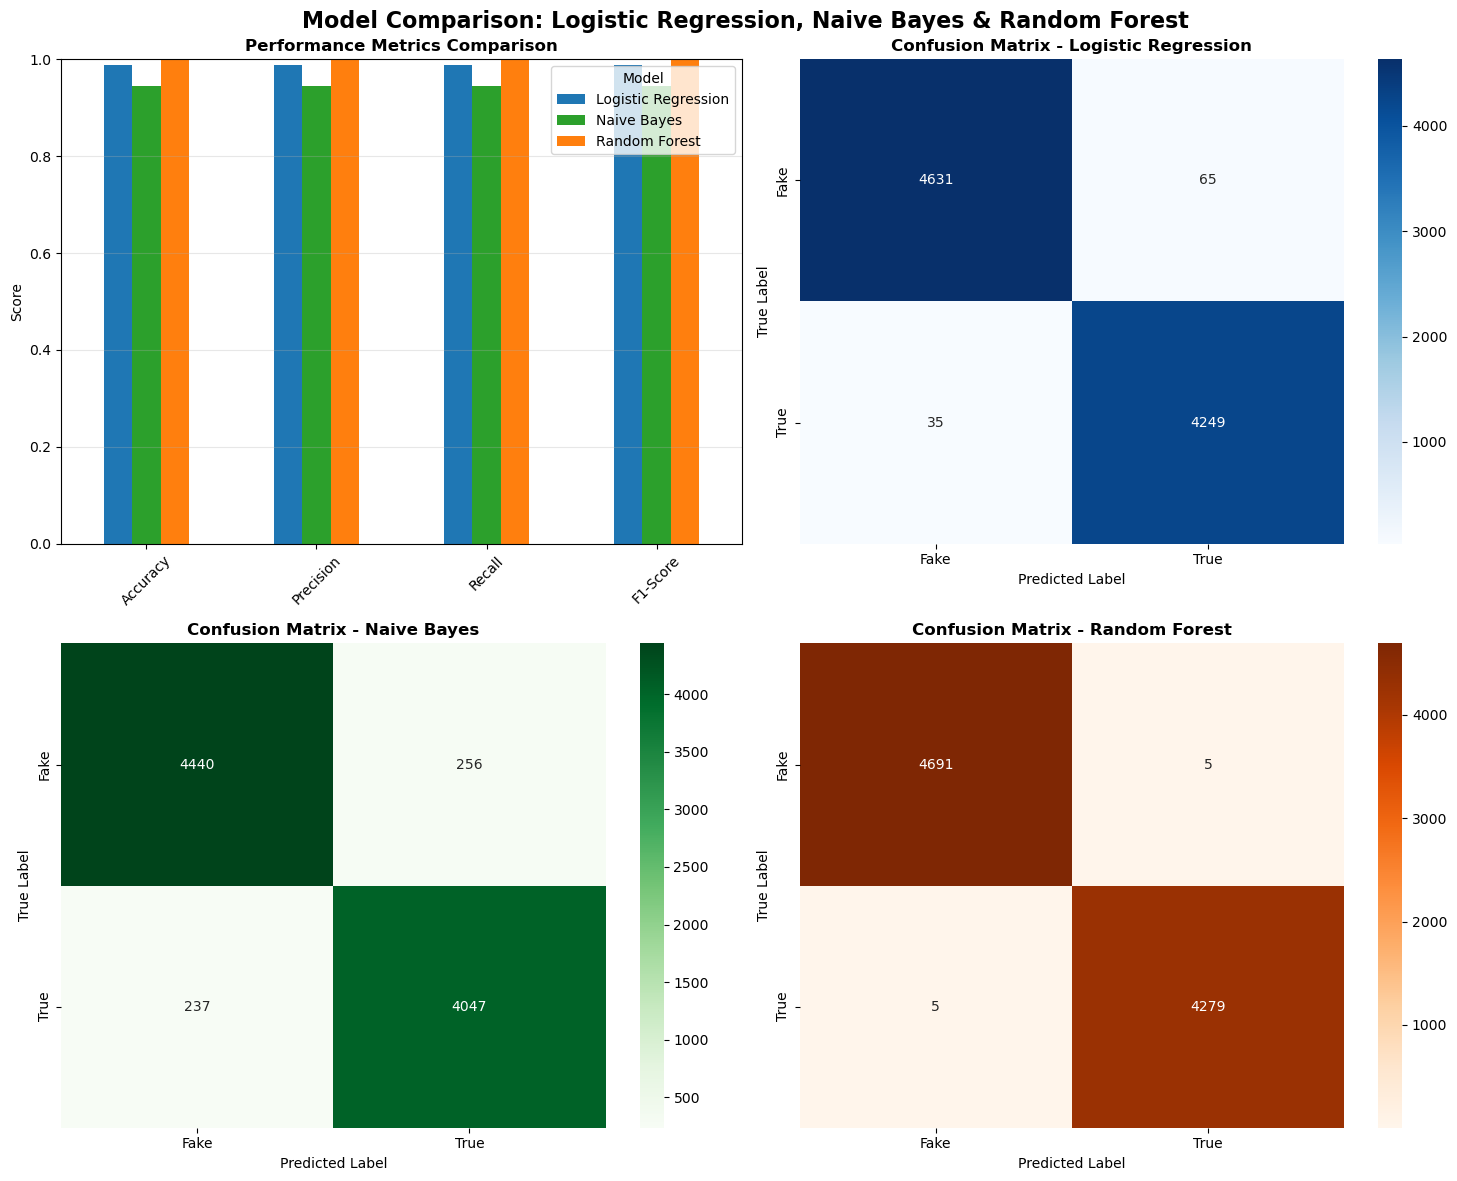

In [22]:
# ================================================================
# VISUALIZATIONS
# ================================================================

print("\nCreating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Comparison: Logistic Regression, Naive Bayes & Random Forest', 
             fontsize=16, fontweight='bold')

# Plot 1: Metrics Comparison (Bar Chart) - Updated for 3 models
ax1 = axes[0, 0]
metrics_df = comparison_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score']]
metrics_df.T.plot(kind='bar', ax=ax1, rot=45, color=['#1f77b4', '#2ca02c', '#ff7f0e'])  # Blue, Green, Orange for LR, NB, RF
ax1.set_title('Performance Metrics Comparison', fontsize=12, fontweight='bold')
ax1.set_ylabel('Score')
ax1.set_ylim([0, 1])
ax1.legend(title='Model')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Confusion Matrix - Logistic Regression
ax2 = axes[0, 1]
cm_lr = confusion_matrix(y_test, lr_pred)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
ax2.set_title('Confusion Matrix - Logistic Regression', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

# Plot 3: Confusion Matrix - Naive Bayes
ax3 = axes[1, 0]
cm_nb = confusion_matrix(y_test, nb_pred)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens', ax=ax3,
            xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
ax3.set_title('Confusion Matrix - Naive Bayes', fontsize=12, fontweight='bold')
ax3.set_ylabel('True Label')
ax3.set_xlabel('Predicted Label')

# Plot 4: Confusion Matrix - Random Forest
ax4 = axes[1, 1]
cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges', ax=ax4,
            xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
ax4.set_title('Confusion Matrix - Random Forest', fontsize=12, fontweight='bold')
ax4.set_ylabel('True Label')
ax4.set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('models/model_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved to: models/model_comparison.png")
plt.show()

In [23]:
# ================================================================
# SAVE RESULTS
# ================================================================

print("\nSaving comparison results...")

# Save comparison table (now with 3 models)
comparison_df.to_csv('models/model_comparison_results.csv', index=False)
print("✓ Results saved to: models/model_comparison_results.csv")

print("\n" + "="*60)
print("✓ ANALYSIS COMPLETE!")
print("="*60)


Saving comparison results...
✓ Results saved to: models/model_comparison_results.csv

✓ ANALYSIS COMPLETE!


In [24]:
# ================================================================
# DEBUG CELL - RUN THIS FIRST IF PATH ISSUES
# ================================================================

import os

print("Current working directory:", os.getcwd())
print("Files in current directory:", os.listdir('.'))

if os.path.exists('data'):
    print("✓ 'data' folder found!")
    print("Contents of 'data':", os.listdir('data'))
    if os.path.exists('data/raw'):
        print("✓ 'data/raw' folder found!")
        print("Contents of 'data/raw':", os.listdir('data/raw'))
        if os.path.exists('data/raw/Fake.csv'):
            print("✓ 'Fake.csv' found!")
        else:
            print("❌ 'Fake.csv' not found in 'data/raw'")
    else:
        print("❌ 'data/raw' folder not found")
else:
    print("❌ 'data' folder not found")

Current working directory: C:\Users\cheta\OneDrive\Desktop\fake-news-detection-genai
Files in current directory: ['.git', '.ipynb_checkpoints', '.virtual_documents', 'data', 'models', 'naive_bayes_comparison.ipynb-Copy1.ipynb', 'naive_bayes_comparison.ipynb.ipynb', 'notebooks', 'README.md']
✓ 'data' folder found!
Contents of 'data': ['raw']
✓ 'data/raw' folder found!
Contents of 'data/raw': ['Fake.csv', 'IFND.csv', 'True.csv']
✓ 'Fake.csv' found!
